In [ ]:
!pip install kornia

In [ ]:
!git clone https://github.com/kornia/kornia-examples

In [3]:
!mv kornia-examples/* .

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import kornia

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Using ', device)

Using  cpu


In [6]:
def load_data(filename):
    data_np = np.load(filename)
    data = torch.from_numpy(data_np)
    return data

def data_to_vis(data):
    return kornia.tensor_to_image(data)


In [7]:
# load the camera matrix
intrinsics_1 = load_data('data/depth/camera_intrinsics_0.npy')[..., :3, :3]  # 1x3x3
intrinsics_2 = load_data('data/depth/camera_intrinsics_1.npy')[..., :3, :3]  # 1x3x3
intrinsics_3 = load_data('data/depth/camera_intrinsics_2.npy')[..., :3, :3]  # 1x3x3

# load the camera pose
pose_w_1 = load_data('data/depth/camera_pose_0.npy')  # 1x4x4
pose_w_2 = load_data('data/depth/camera_pose_1.npy')  # 1x4x4
pose_w_3 = load_data('data/depth/camera_pose_2.npy')  # 1x4x4

# load images
image_1 = load_data('data/depth/image_0.npy')  # 1x3xHxW
image_2 = load_data('data/depth/image_1.npy')  # 1x3xHxW
image_3 = load_data('data/depth/image_2.npy')  # 1x3xHxW

# load the depth map (in meters)
depth_1 = load_data('data/depth/depth_0.npy')  # 1x1xHxW
depth_2 = load_data('data/depth/depth_1.npy')  # 1x1xHxW
depth_3 = load_data('data/depth/depth_2.npy')  # 1x1xHxW


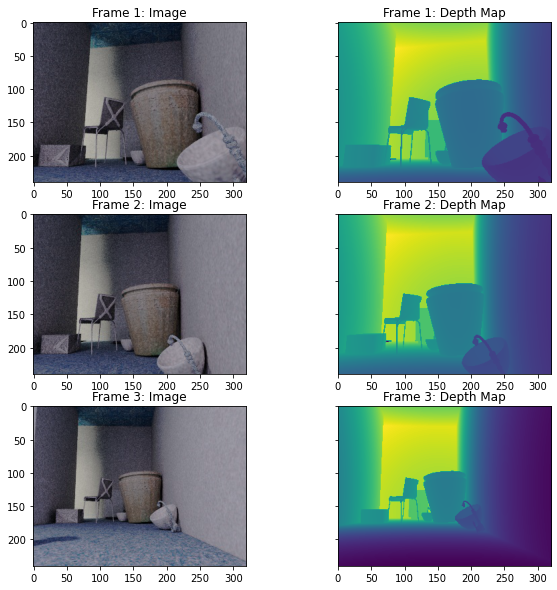

In [8]:
%matplotlib inline
fig, axes = plt.subplots(3, 2, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(10)

axes[0, 0].imshow(data_to_vis(image_1))
axes[0, 0].set_title('Frame 1: Image')

axes[0, 1].imshow(data_to_vis(depth_1))
axes[0, 1].set_title('Frame 1: Depth Map')

axes[1, 0].imshow(data_to_vis(image_2))
axes[1, 0].set_title('Frame 2: Image')

axes[1, 1].imshow(data_to_vis(depth_2))
axes[1, 1].set_title('Frame 2: Depth Map')

axes[2, 0].imshow(data_to_vis(image_3))
axes[2, 0].set_title('Frame 3: Image')

axes[2, 1].imshow(data_to_vis(depth_3))
axes[2, 1].set_title('Frame 3: Depth Map')
plt.show()

# First Method to Implement Loss function
In this case, we are evaluating the predicted transformation matrix(not depth). In the first method, we don't compute 3D point clouds and then apply relative transformations to them. Rather, we synthesize the next depth image using the current depth and relative transformation, and compare it to the ground truth next depth.


In [85]:
# Here we are using predicted transformation matrix
k_trans_j = pose_w_3 @ torch.inverse(pose_w_2)

predicted_depth_2 = kornia.geometry.warp_frame_depth(
    image_src=depth_3,
    depth_dst=depth_2,
    src_trans_dst=k_trans_j,
    camera_matrix=intrinsics_2,
    normalize_points=True
)

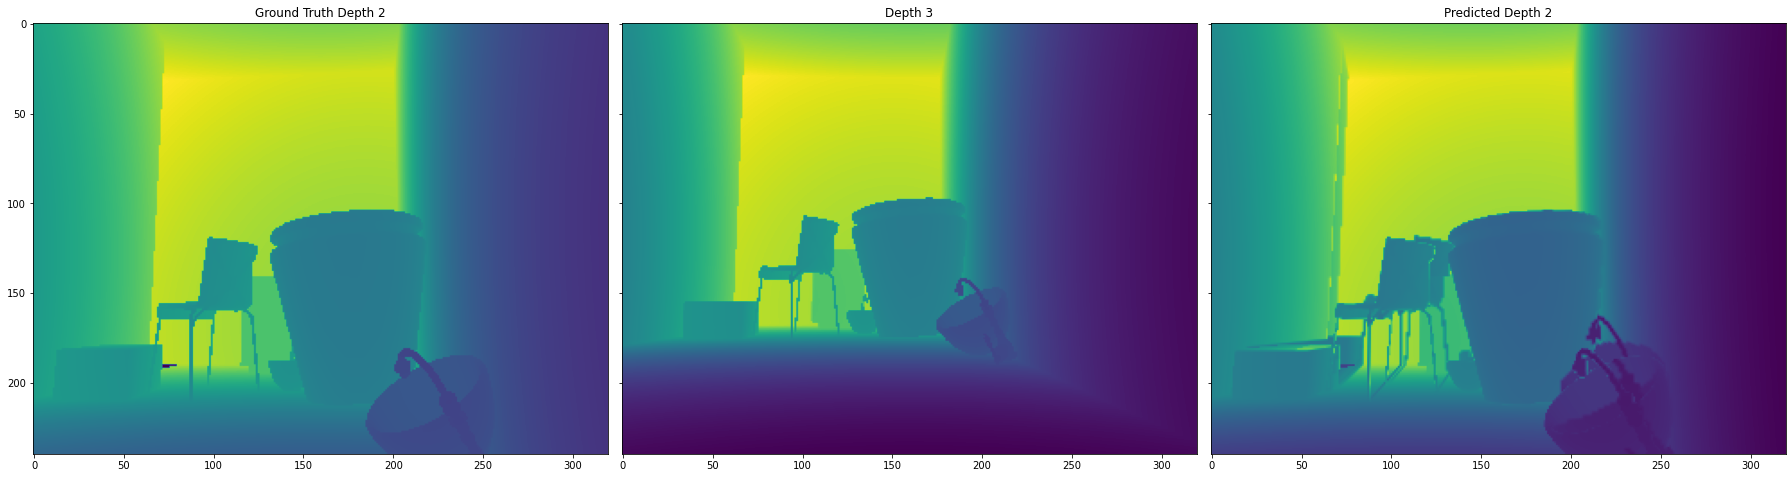

In [86]:
%matplotlib inline
fig, axes = plt.subplots(1, 3, sharey=True)
fig.set_figheight(25)
fig.set_figwidth(25)

axes[0].imshow(data_to_vis(depth_2))
axes[0].set_title('Ground Truth Depth 2')

axes[1].imshow(data_to_vis(depth_3))
axes[1].set_title('Depth 3')

axes[2].imshow(data_to_vis(predicted_depth_2))
axes[2].set_title('Predicted Depth 2')
plt.show()

In [87]:
loss = torch.nn.L1Loss()
output = loss(depth_2, predicted_depth_2)
output

tensor(0.8922)

In [28]:
# Here we are using predicted transformation matrix
j_trans_k = pose_w_2 @ torch.inverse(pose_w_3)

predicted_depth_3 = kornia.geometry.warp_frame_depth(
    image_src=depth_2,
    depth_dst=depth_3,
    src_trans_dst=j_trans_k,
    camera_matrix=intrinsics_2,
    normalize_points=True
)

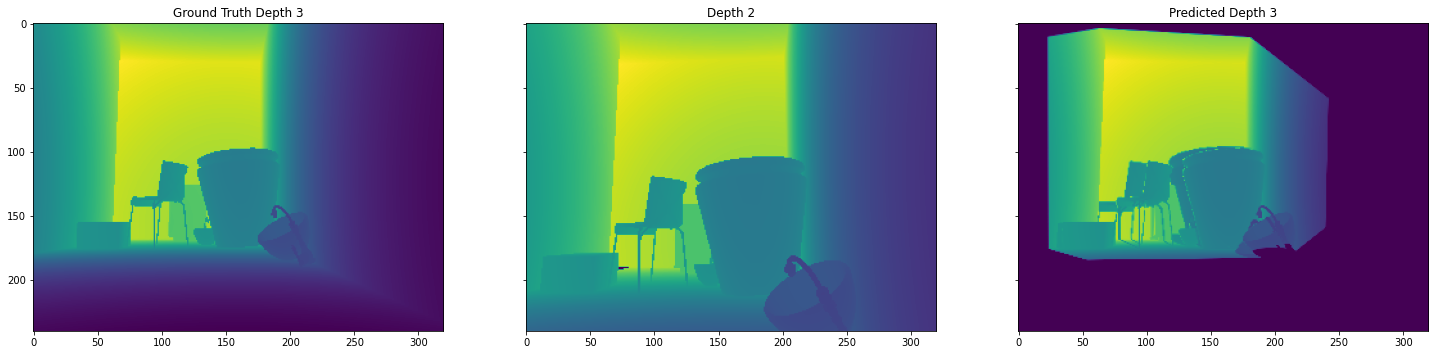

In [29]:
%matplotlib inline
fig, axes = plt.subplots(1, 3, sharey=True)
fig.set_figheight(25)
fig.set_figwidth(25)

axes[0].imshow(data_to_vis(depth_3))
axes[0].set_title('Ground Truth Depth 3')

axes[1].imshow(data_to_vis(depth_2))
axes[1].set_title('Depth 2')

axes[2].imshow(data_to_vis(predicted_depth_3))
axes[2].set_title('Predicted Depth 3')
plt.show()

In [30]:
loss = torch.nn.L1Loss()
output = loss(depth_3, predicted_depth_3)
output

tensor(1.4540)

### Predict with an relative transformation

In [55]:
# Here we are using predicted transformation matrix
# k_trans_j = pose_w_3 @ torch.inverse(pose_w_2)
k_trans_j = torch.from_numpy(np.random.rand(4, 4))

k_trans_j = k_trans_j.expand(1, 4, 4)
k_trans_j = k_trans_j.float()

print(k_trans_j)

predicted_depth_2 = kornia.geometry.warp_frame_depth(
    image_src=depth_3,
    depth_dst=depth_2,
    src_trans_dst=k_trans_j,
    camera_matrix=intrinsics_2,
    normalize_points=True
)

tensor([[[0.8091, 0.7845, 0.9718, 0.9509],
         [0.3180, 0.4818, 0.9932, 0.9041],
         [0.5417, 0.2976, 0.7290, 0.8134],
         [0.5035, 0.9012, 0.4409, 0.5254]]])


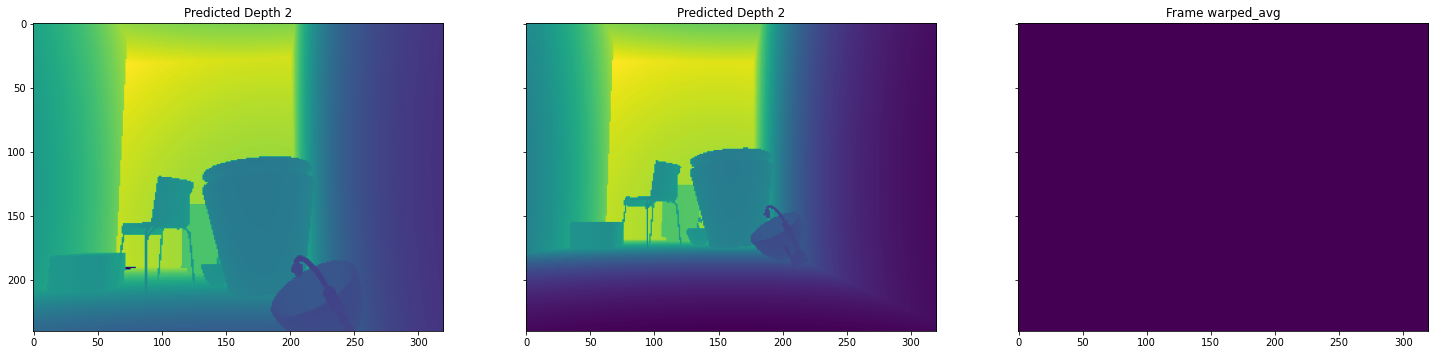

In [56]:
%matplotlib inline
fig, axes = plt.subplots(1, 3, sharey=True)
fig.set_figheight(25)
fig.set_figwidth(25)

axes[0].imshow(data_to_vis(depth_2))
axes[0].set_title('Predicted Depth 2')

axes[1].imshow(data_to_vis(depth_3))
axes[1].set_title('Predicted Depth 2')

axes[2].imshow(data_to_vis(predicted_depth_2))
axes[2].set_title('Frame warped_avg')
plt.show()

In [57]:
loss = torch.nn.L1Loss()
output = loss(depth_2, predicted_depth_2)
output

tensor(3.1334)

# Second Method to Implement Loss function

## 

In [113]:
k_trans_j = pose_w_3 @ torch.inverse(pose_w_2)

In [120]:
points_3d_2: torch.Tensor =  kornia.geometry.depth_to_3d(depth_2, intrinsics_2, True)  # Bx3xHxW

points_3d_2 = point_3d_2.permute(0, 2, 3, 1)  # BxHxWx3

# apply transformation to the 3d points
points_3d_3_predicted = kornia.geometry.linalg.transform_points(k_trans_j[:, None], point_3d_2)  # BxHxWx3

points_3d_3: torch.Tensor =  kornia.geometry.depth_to_3d(depth_3, intrinsics_3, True)  # Bx3xHxW
points_3d_3 = points_3d_3.permute(0, 2, 3, 1)  # BxHxWx3

print(points_3d_3.shape)
print(points_3d_3_predicted.shape)

loss = torch.nn.L1Loss()
output = loss(points_3d_3_predicted, points_3d_3)
output

torch.Size([1, 240, 320, 3])
torch.Size([1, 240, 320, 3])


tensor(5.0450)

In [115]:
points_3d_3 = np.array(points_3d_3[0])
points_3d_3_predicted = np.array(points_3d_3_predicted[0])

print(points_3d_3.shape)
print(points_3d_3_predicted.shape)

(240, 320, 3)
(240, 320, 3)


In [119]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = points_3d_3[:, :, 0]
y = points_3d_3[:, :, 1]
z = points_3d_3[:, :, 2]
ax.scatter(x, y, z, c=z, alpha=1)
plt.show()


In [117]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = points_3d_3_predicted[:, :, 0]
y = points_3d_3_predicted[:, :, 1]
z = points_3d_3_predicted[:, :, 2]
ax.scatter(x, y, z, c=z, alpha=1)
plt.show()

In [101]:
points_3d_3: torch.Tensor =  kornia.geometry.depth_to_3d(depth_3, intrinsics_3, True)  # Bx3xHxW

# transform points from source to destination
points_3d_3 = points_3d_3.permute(0, 2, 3, 1)  # BxHxWx3

# apply transformation to the 3d points
points_3d_2_predicted = kornia.geometry.linalg.transform_points(torch.inverse(k_trans_j)[:, None], points_3d_3)  # BxHxWx3

points_3d_2: torch.Tensor =  kornia.geometry.depth_to_3d(depth_2, intrinsics_2, True)  # Bx3xHxW
points_3d_2 = points_3d_2.permute(0, 2, 3, 1)  # BxHxWx3

print(points_3d_2.shape)
print(points_3d_2_predicted.shape)

loss = torch.nn.L1Loss()
output = loss(points_3d_2, points_3d_2_predicted)
output

torch.Size([1, 240, 320, 3])
torch.Size([1, 240, 320, 3])


tensor(0.4074)

In [102]:
points_3d_2 = np.array(points_3d_2[0])
points_3d_2_predicted = np.array(points_3d_2_predicted[0])

print(points_3d_2.shape)
print(points_3d_2_predicted.shape)

(240, 320, 3)
(240, 320, 3)


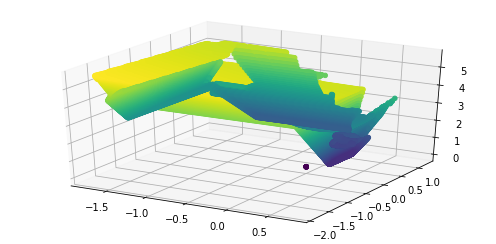

In [107]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = points_3d_2[:, :, 0]
y = points_3d_2[:, :, 1]
z = points_3d_2[:, :, 2]
ax.scatter(x, y, z, c=z, alpha=1)
plt.show()


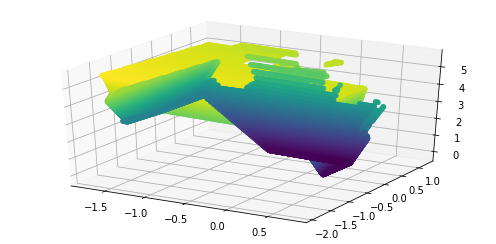

In [110]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = points_3d_2_predicted[:, :, 0]
y = points_3d_2_predicted[:, :, 1]
z = points_3d_2_predicted[:, :, 2]
ax.scatter(x, y, z, c=z, alpha=1)
plt.show()
